In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from simdata import HT_sim, scaler,fdd, pdeinp,icinp,bcinp


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
L = 15e-3

time_end = 5.0
numpoints = 50
t_surr = 500.0
temp_init = 919.0



In [3]:
heat_data = HT_sim(L, time_end, numpoints,  t_surr,temp_init)
alpha = heat_data.alpha_l
print(alpha)
tempfield = heat_data.datagen()
print(tempfield.shape)

3.394878564540885e-05
(3935, 50)


In [4]:

# heat_data.plot_temp(25)
x_c = 1/L
t_c = (alpha/(L**2))
temp_c = 919.0

# Temperature dataset
temp_data = tempfield.flatten()

temp_data = temp_data*(1.0/919.0)

# temp_data = scaler(temp_data,400.0,919.0)


# input dataset- fdd
num_steps = tempfield.shape[0]
numpoints = tempfield.shape[1] 
print(numpoints, num_steps)
print(numpoints*num_steps) 
inp_data = fdd(L, time_end, numpoints, num_steps,scl="false")



50 3935
196750


In [5]:
def pde(x, y):
    # pde for heat equation
    dy_t = dde.grad.jacobian(y, x, j=0)
    dy_xx = dde.grad.hessian(y, x, j=1)
    return dy_t - dy_xx

def scale2(x,x_c,t_c):
    x[:,0] = x[:,0] * x_c
    x[:,1] = x[:,1] * t_c
    return x

In [6]:
geom = dde.geometry.Interval(0, (L*x_c))

timedomain = dde.geometry.TimeDomain(0, (time_end*t_c))
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.DirichletBC(geomtime, lambda x: (500.0/919.0), lambda _, on_boundary: on_boundary)

ic = dde.IC(geomtime, lambda x: (919.0/919.0), lambda _, on_initial: on_initial)

In [7]:
data = dde.data.TimePDE(geomtime, \
                        pde,\
                        [bc, ic], \
                      num_domain=30000, \
                     num_boundary=5000, \
                        num_initial=5000, num_test=10000)

In [8]:
net = dde.maps.FNN([2] + [10] * 9 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)



In [9]:
model.compile("adam", lr=0.0001)



losshistory, train_state = model.train(iterations=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.035931 s

'compile' took 0.201182 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.46e-02, 1.83e-01, 7.66e-01]    [7.12e-02, 1.83e-01, 7.66e-01]    []  


I0000 00:00:1739760741.625787 19866985 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


1000      [2.03e-03, 2.51e-02, 5.80e-03]    [1.61e-03, 2.51e-02, 5.80e-03]    []  

Best model at step 1000:
  train loss: 3.30e-02
  test loss: 3.26e-02
  test metric: []

'train' took 44.092923 s



(196750, 1)
(3935, 50)


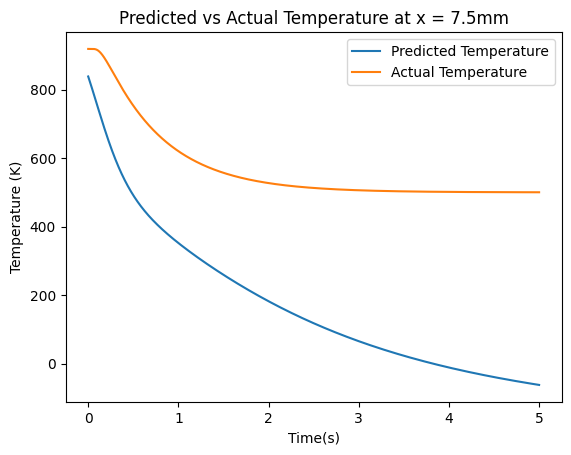

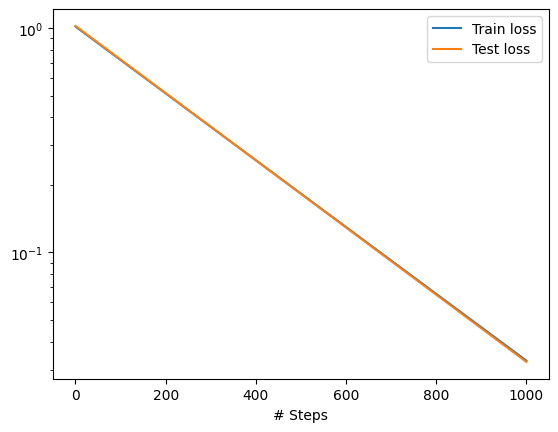

In [10]:
y_pred = model.predict(inp_data)

y_pred = y_pred * 919.0

print(y_pred.shape)
temp_nn = y_pred.reshape(num_steps, numpoints)
print(temp_nn.shape)
time_ss= np.linspace(0, time_end, num_steps )

plt.figure
plt.plot(time_ss, temp_nn[:,24 ], label='Predicted Temperature')
plt.plot(time_ss, tempfield[:,24], label='Actual Temperature')
plt.xlabel('Time(s)')
plt.ylabel('Temperature (K)')
plt.yscale('linear')
plt.title('Predicted vs Actual Temperature at x = 7.5mm')
plt.legend()
plt.show()

dde.utils.external.plot_loss_history(losshistory)